In [247]:
import pandas as pd
import numpy as np
import math
import random
import matplotlib.pylab as plt

In [248]:
n = 50 # 粒子总数
dim = 2 # 问题空间维度
algo = 1 # 算法选择
rang = 500 # 活动范围
Vmax = rang # 速度最大值
M = 10 # 子群个数
P = int(n/M) #每个子群个体数

c1 = 2
c2 = 2

k1 = 5 # 逃逸阈值
k2 = 10 # 控制阈值下降幅度

swarm = [] # 粒子群
swarm_best_pos = [] # 粒子群最佳位置
swarm_best_fitness = 0 # 粒子群最佳适应度
sigma = [rang**2 for _ in range(M)] # 高斯变异算子 sigma
FitXm = [0 for _ in range(M)] # 每个子群的总适应度值
Td = [0 for _ in range(dim)] # 每个维度的逃逸阈值
G = [0 for _ in range(dim)] # 每个维度的逃逸次数

In [249]:
# 选择待解决问题
def algo_choose(name):
    if name == 1:
        print('Tablet Function ')
        algo = 1
        rang = 500
    if name == 2:
        print('Quadratic function')
        dim = 1 #二次函数只有一个变量-0.25[1.5]
        algo = 2
        rang = 100
    if name == 3:
        print('Rosenbrock function')
        algo = 3#完美结果0 [1,1,1,1,1,1]
        rang = 5
    if name == 4:
        print('Griewank Function')
        algo = 4#计算精度不够，0 [0,0,0,0,0]
        rang = 600
    if name == 5:
        print('Rastrigin Funtion')
        algo = 5 # 0[0,0,0,0,0]
        rang = 5.12
    if name == 6:
        print('Schaffer\'s F7 Problem')
        algo = 6 # 0[0,0,0,0] 
        rang = 100

In [250]:
# 论文中给出的需要解决的问题及计算适应值的公式
def cal_fitness(x):
    if algo == 1:
        res=0
        for i in range(1,dim):
            res = res + x[i]*x[i]
        return res+x[0]*x[0]*1000
    if algo == 2:
        res=0
        a = 1
        b = -3
        c = 2
        return a*x[0]*x[0]+b*x[0]+c
    if algo == 3:
        res = 0
        for i in range(dim-1):
            res = res + (100*(x[i+1]-x[i]*x[i])*(x[i+1]-x[i]*x[i])+(x[i]-1)*(x[i]-1))
        return res
    if algo == 4:
        res1 = 0
        res2 = 1
        for i in range(dim):
            res1 = sum1 + x[i]*x[i]/4000
            res2 = sum2 * math.cos(x[i]/math.sqrt(i+1))
        return res1-res2+1
    if algo == 5:
        res = 0
        for i in range(dim):
            res = res + x[i]*x[i] -10*math.cos(2*math.pi*x[i]) +10
        return sum
    if algo == 6:
        res = 0
        normalizer = 1.0/float(len(x)-1)
        for i in range(len(x)-1):
            si = math.sqrt(x[i]**2 + x[i+1]**2)
            res += (normalizer * math.sqrt(si) * (math.sin(50*si**0.20) + 1))**2
        return res

In [251]:
class Swarm:
    def __init__(self):
        # 个体当前位置
        self.pos = [np.random.uniform(-rang, rang) for _ in range(dim)]
        # 个体当前速度
        self.speed = [0 for _ in range(dim)]
        # 个体当前适应值
        self.fitness = cal_fitness(self.pos)
        # 个体最佳适应值
        self.best_fitness = self.fitness
        # 个体最佳适应值下的位置
        self.best_pos = (self.pos).copy()
    
    # 更新适应值，个体最优，全体最优
    def refresh_fitness(self):
        global swarm_best_fitness, swarm_best_pos
        self.fitness = cal_fitness(self.pos)
        # 更新个体最优值
        if(self.fitness < self.best_fitness):
            self.best_fitness = self.fitness
            self.best_pos = (self.pos).copy()
        # 更新全局最优值
        if(self.fitness < swarm_best_fitness):
            swarm_best_fitness = self.fitness
            swarm_best_pos = (self.pos).copy()
    
    # 更新速度，向着个体最优和全体最优变化
    def refresh_speed(self):
        for i in range(dim):
            # 向个体最优和全体最优更新变化
            next_speed = self.speed[i] + c1*np.random.random() * (self.best_pos[i] - self.pos[i]) + c2*np.random.random() * (swarm_best_pos[i] - self.pos[i])
            # 更新速度，越界则不处理
            if(-Vmax < next_speed and next_speed < Vmax):
                self.speed[i] = next_speed
            else:
                pass
            
    # 更新位置
    def refresh_pos(self):
        for i in range(dim):
            next_pos = self.pos[i] + self.speed[i]
            # 更新位置，越界则不处理
            if(-rang < next_pos and next_pos < rang):
                self.pos[i] = next_pos
            else:
                pass
    
    # 逃逸变异
    def escape(self, group):
        global G, sigma
        fitness_a = cal_fitness([self.pos[i] + np.random.random() * sigma[group] for i in range(dim)])
        fitness_b = cal_fitness([self.pos[i] + np.random.random() * Vmax for i in range(dim)])

        is_less = False

        for i in range(dim):
                if self.speed[i] < Td[i]:
                    is_less = True
                    break
                
        if is_less == True:
            for j in range(M):
                tmp_pos = self.pos.copy()
                for i in range(dim):
                    tmp_pos[i] = self.pos[i] + random.random()*sigma[j]
                tmp_fitness = cal_fitness(tmp_pos)
                if tmp_fitness < fitness_a:
                    fitness_a = tmp_fitness

            for i in range(dim):
                if fitness_a < fitness_b:
                    self.speed[i] = sigma[group] * random.random()
                else:
                    self.speed[i] = random.random() * Vmax

                G[i] += 1

In [252]:
# 计算每一个子群的适应度值
def cal_FitXm():
    global swarm
    for i in range(M):
        res = 0
        for j in range(i*P,i*P+P):
            res = res + swarm[j].fitness
        FitXm[i] = res / P

# 计算高斯变异算子的标准差
def cal_sigma():
    FitX_max = max(FitXm)
    FitX_min = min(FitXm)

    for i in range(M):
        sigma[i] = sigma[i]*math.exp(((M*FitXm[i])-(sum(FitXm)))/(FitX_max-FitX_min))

        while(sigma[i] >= rang*2/4):
            sigma[i] = abs(rang*2/4 - sigma[i])
            
# 更新速度阈值
def update_Td():
    for i in range(dim):
        if(G[i] > k1):
            G[i] = 0
            Td[i] = Td[i]/k2

In [253]:
# 数据初始化
def init():
    global swarm, swarm_best_fitness, swarm_best_pos
    swarm = [Swarm() for i in range(n)]
    swarm_best_fitness = swarm[0].best_fitness
    swarm_best_pos = (swarm[0].best_pos).copy()
    
    global sigma, FitXm, Td, G
    sigma = [rang**2 for _ in range(M)] # 高斯变异算子 sigma
    FitXm = [0 for _ in range(M)] # 每个子群的总适应度值
    Td = [0 for _ in range(dim)] # 每个维度的逃逸阈值
    G = [0 for _ in range(dim)] # 每个维度的逃逸次数

In [254]:
# 画图
def draw_fitness_list(fit_list):
    plt.plot(fit_list)
    plt.draw()
    plt.pause(0.01)
    plt.clf()

Tablet Function 


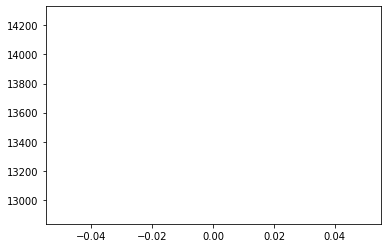

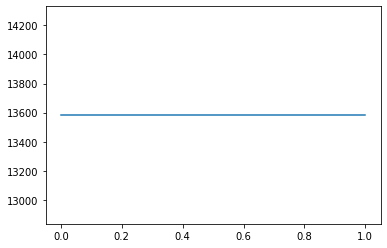

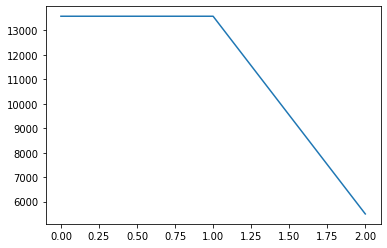

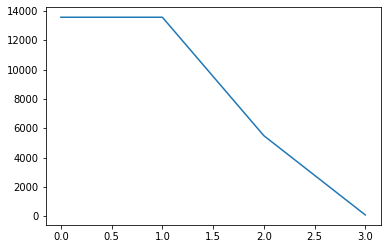

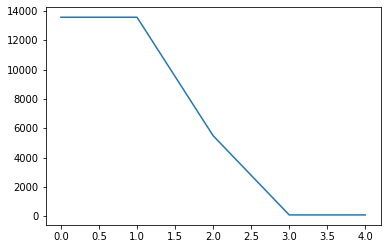

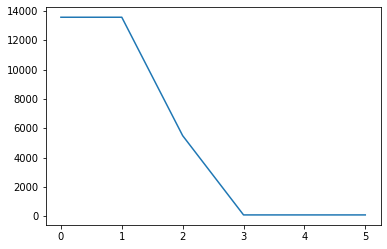

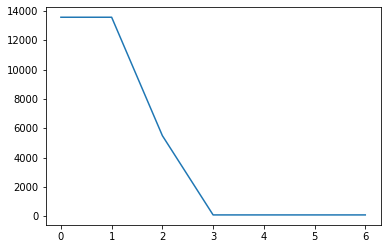

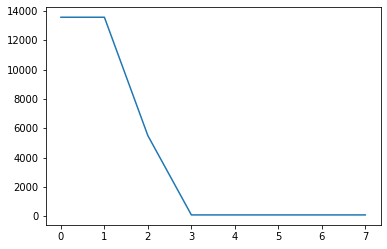

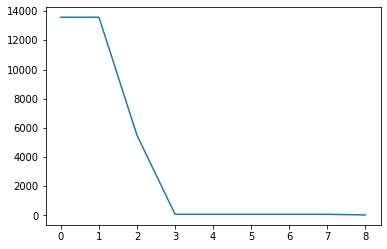

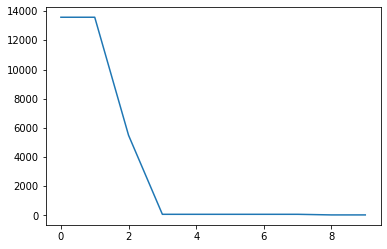

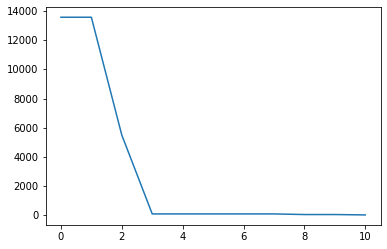

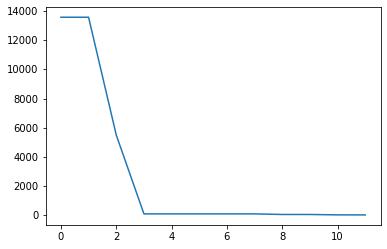

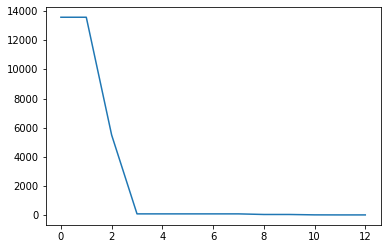

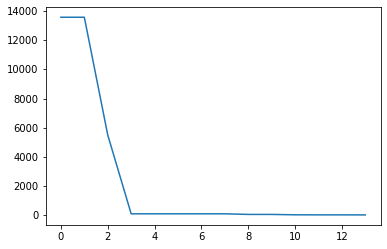

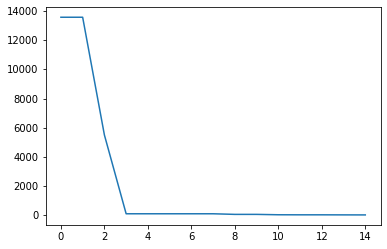

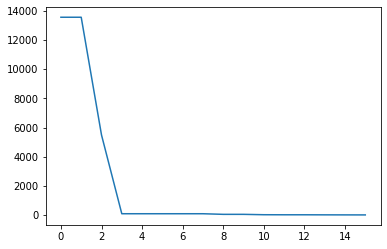

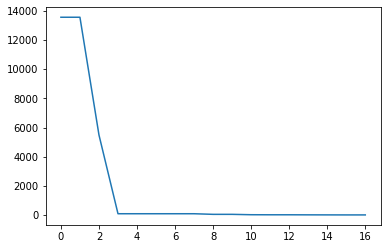

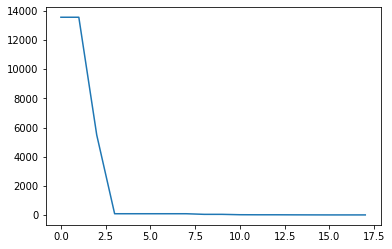

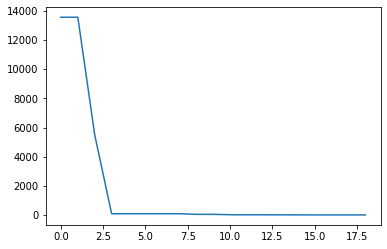

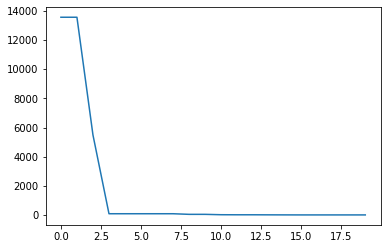

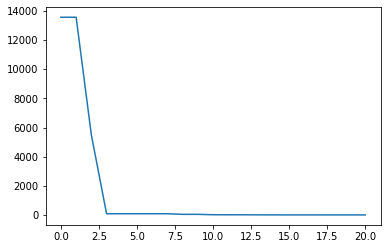

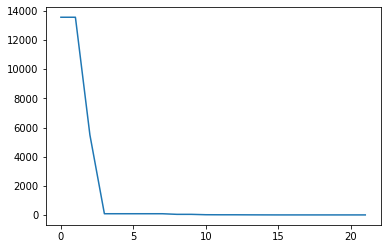

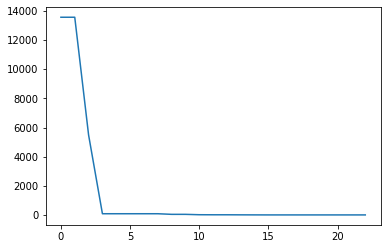

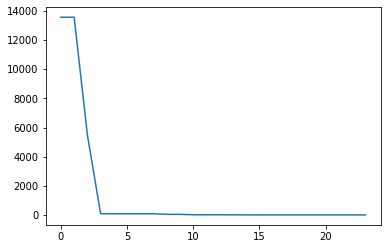

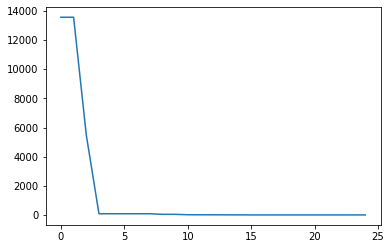

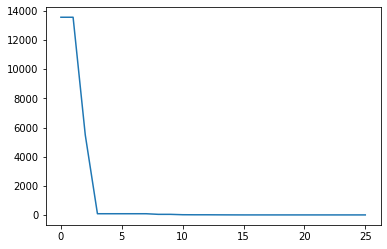

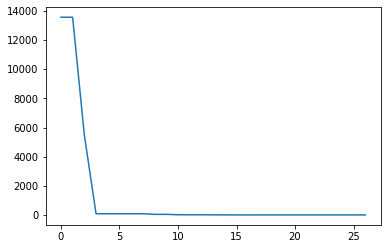

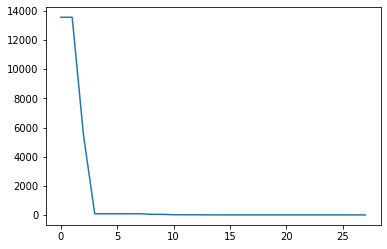

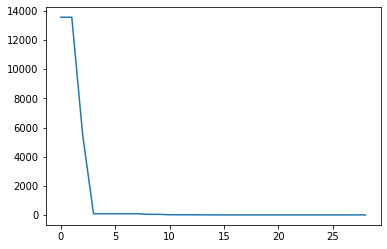

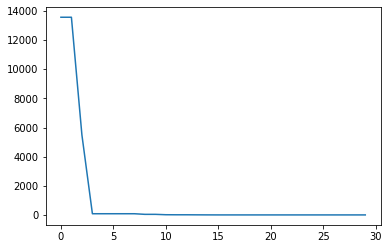

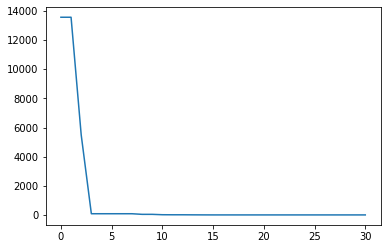

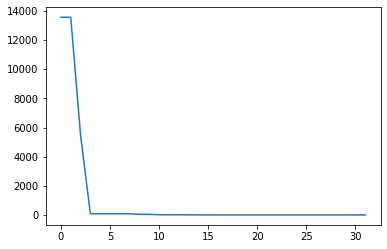

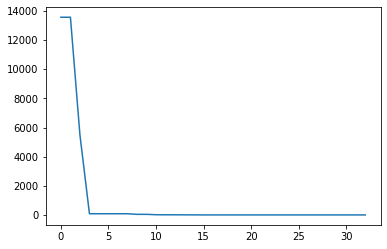

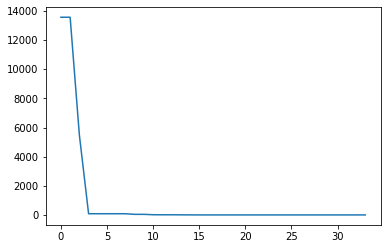

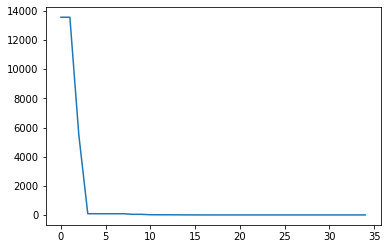

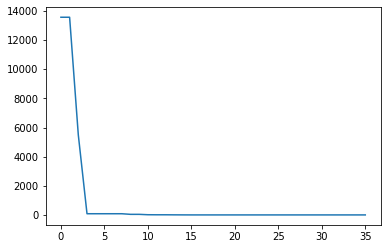

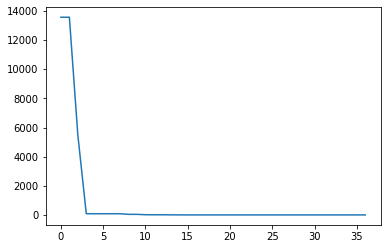

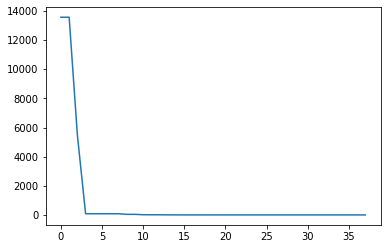

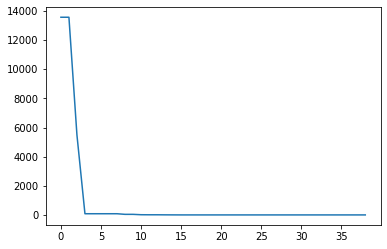

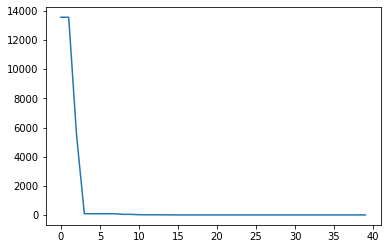

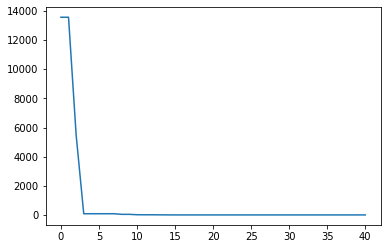

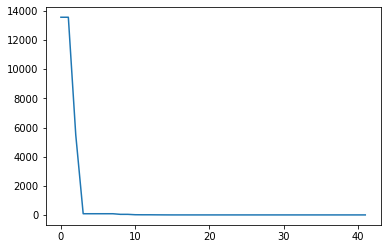

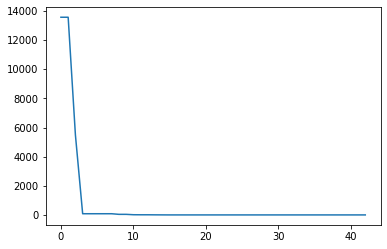

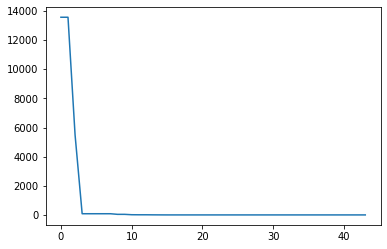

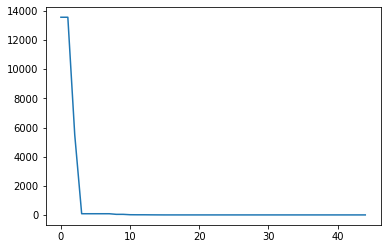

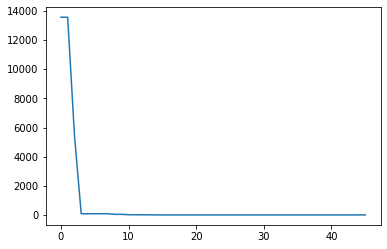

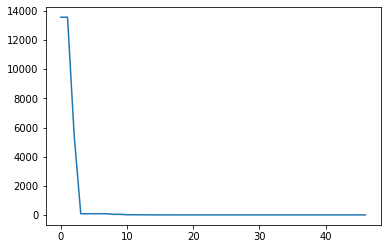

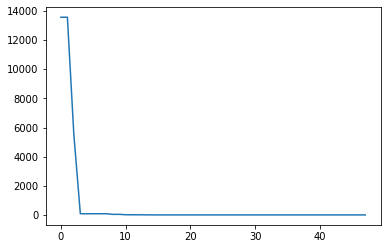

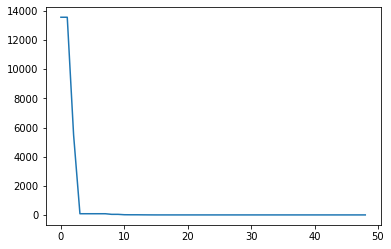

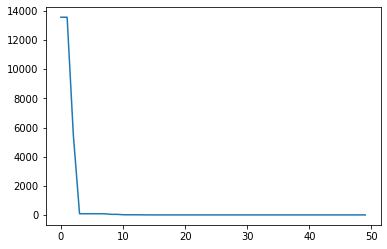

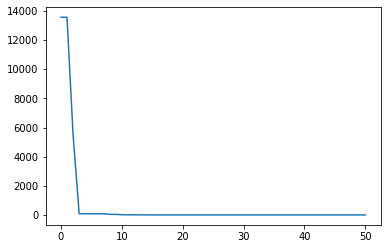

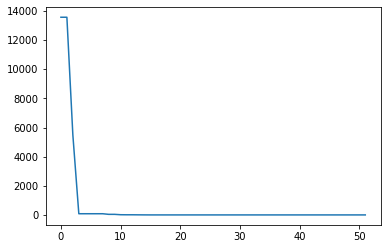

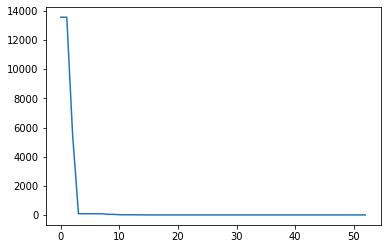

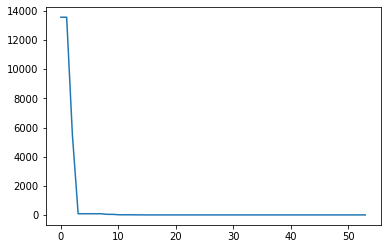

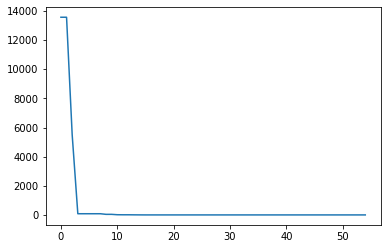

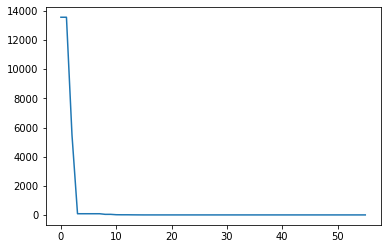

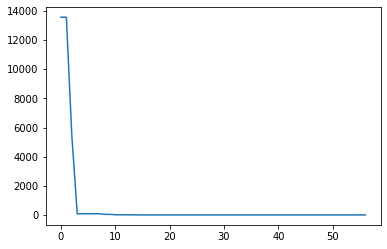

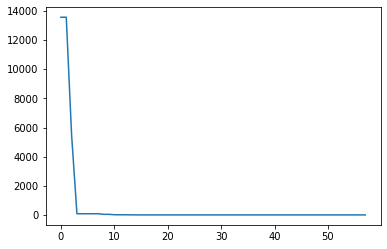

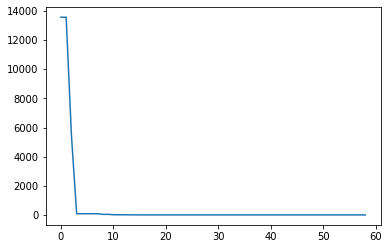

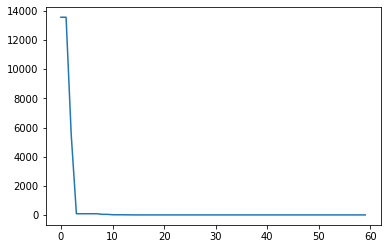

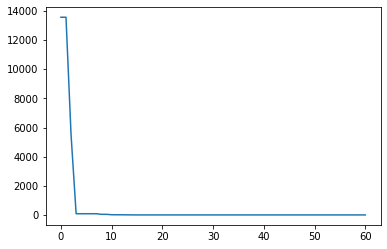

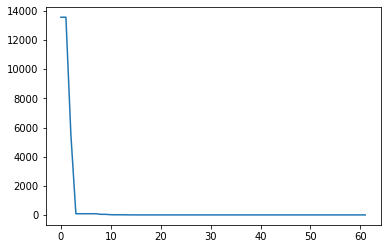

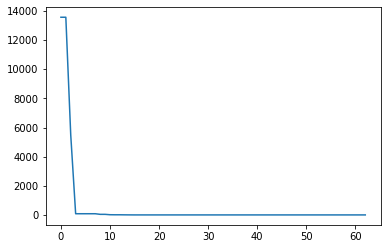

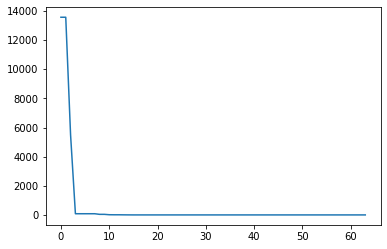

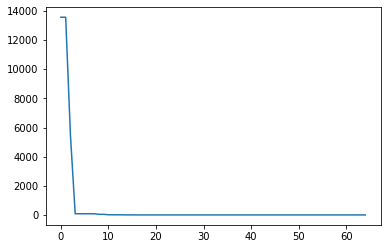

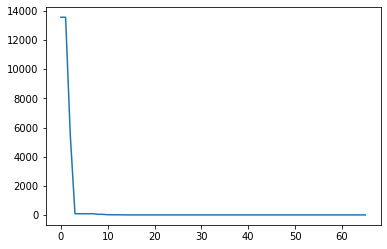

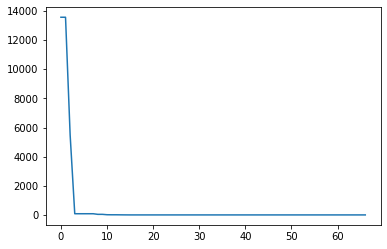

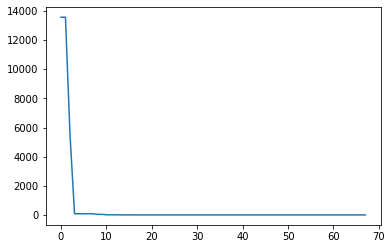

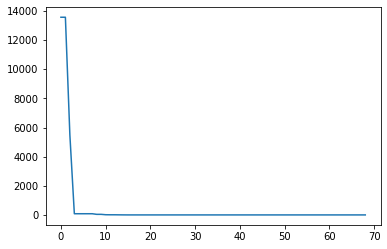

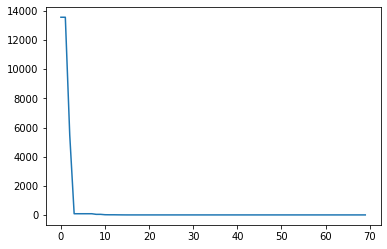

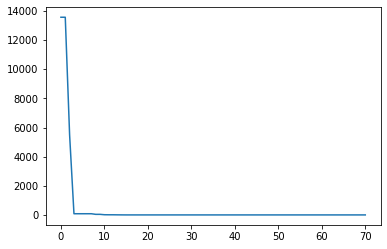

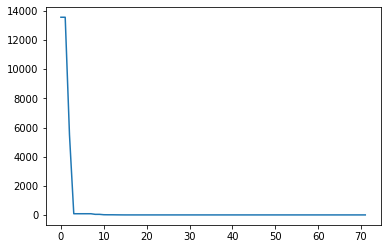

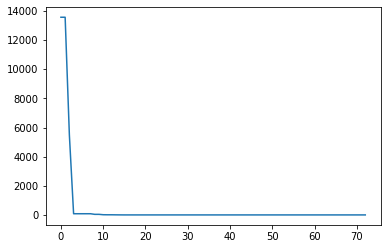

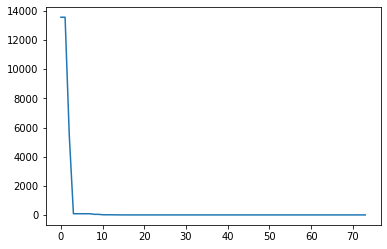

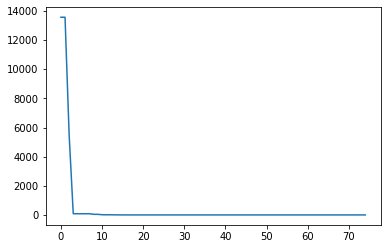

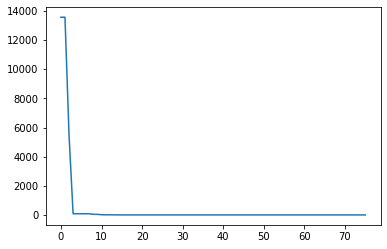

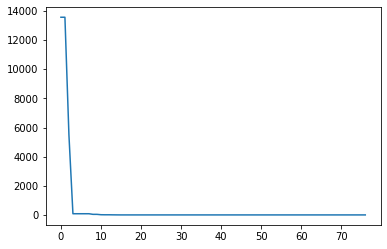

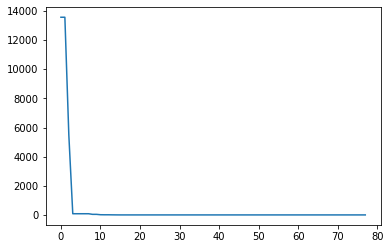

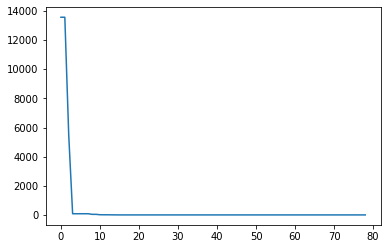

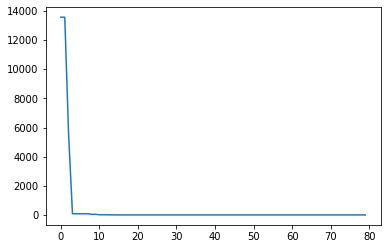

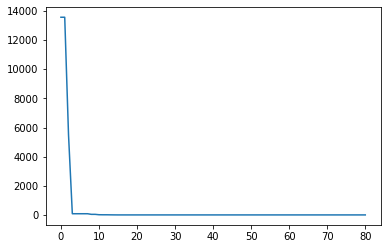

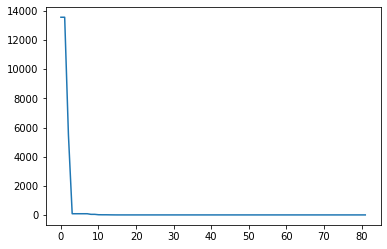

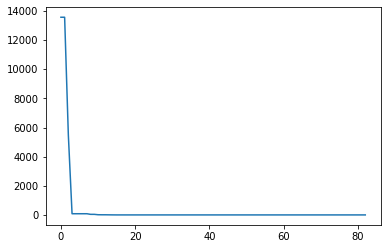

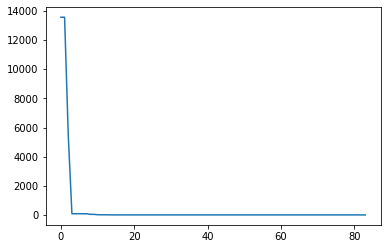

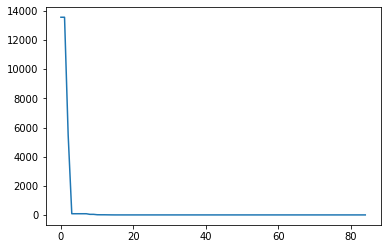

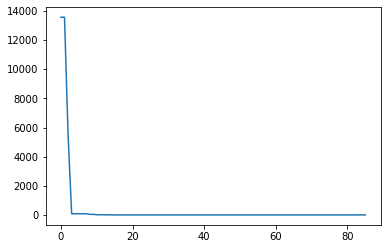

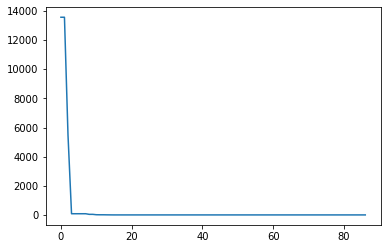

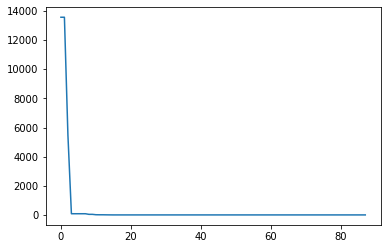

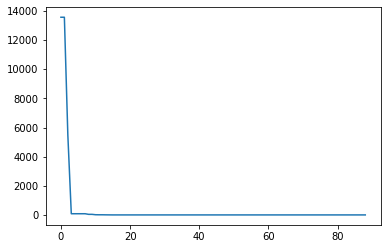

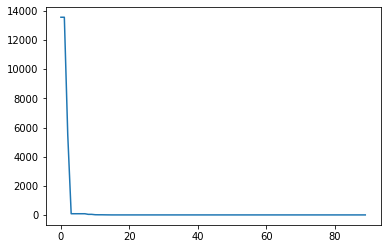

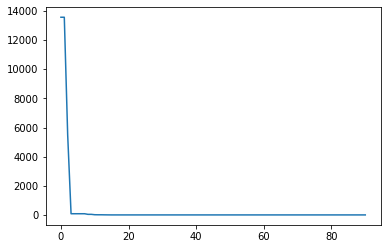

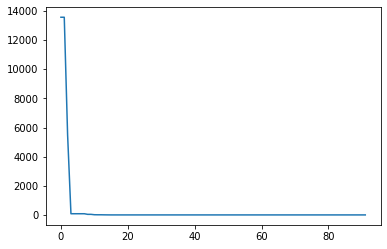

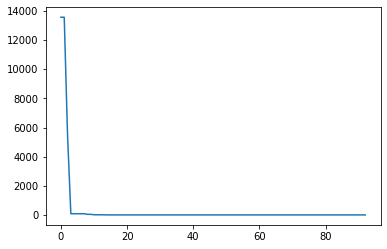

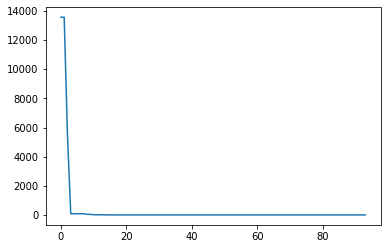

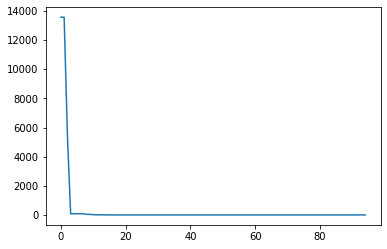

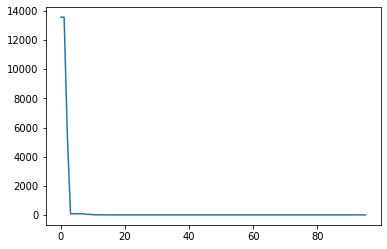

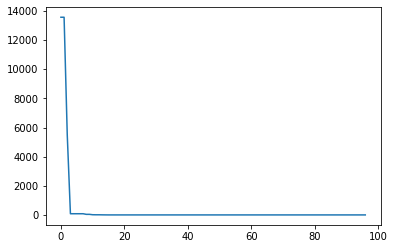

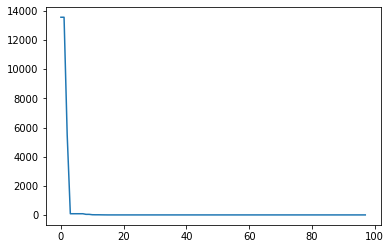

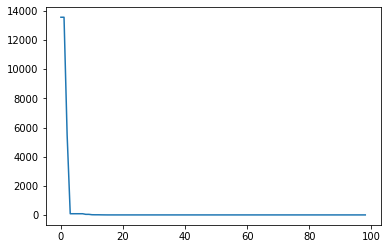

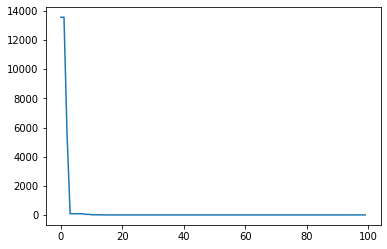

<Figure size 432x288 with 0 Axes>

In [262]:
if __name__ == '__main__':
    
    #迭代次数
    K = 0
    # 选择要解决的问题算法
    algo_choose(1)
    # 初始化数据
    init()
    # 适应值更新历史记录
    fit_list = []
    
    while True:
        # 每一步更新适应值及位置速度
        for i in range(n):
            swarm[i].refresh_fitness()
            swarm[i].refresh_speed()
            swarm[i].refresh_pos()
        # 适应值从小到大排序
        sorted(swarm, key=lambda x:x.fitness, reverse=False)
        # 计算种群适应值
        cal_FitXm()
        # 计算种群变异算子标准差
        cal_sigma()
        
        # 个体变异逃逸
        for i in range(n):
            group = int(i/(n/M))
            swarm[i].escape(group)
            
        # 更新速度阈值
        update_Td()
        # 画图
        fit_list.append(swarm_best_fitness)
        draw_fitness_list(fit_list)
        
        K = K+1
        if K==100:
            break

In [263]:
fit_list

[13583.209216574378,
 13583.209216574378,
 5495.380239043444,
 81.16896905570054,
 81.16896905570054,
 81.16896905570054,
 81.16896905570054,
 81.16896905570054,
 39.25863857901346,
 39.25863857901346,
 13.053556767418746,
 9.30564534001037,
 9.3056450508974,
 5.298908821364643,
 2.4036158224931703,
 0.026214073623980507,
 0.026214073622782545,
 0.01818263655997163,
 0.017451476850166275,
 0.007871266017346236,
 0.00024105044512151845,
 0.00024105044512151845,
 0.00024105044512151845,
 0.0002410504451215184,
 0.0002410504451215184,
 0.0002410504451215184,
 0.00016634338414864668,
 0.00016634338414864668,
 0.00016634338414864668,
 0.00016634338414864668,
 0.00016634338414864668,
 9.914656966512988e-05,
 6.488075512523546e-05,
 5.964986568259128e-05,
 2.1260607361591996e-05,
 2.126060736147533e-05,
 2.1260607361358662e-05,
 1.8271264450068308e-05,
 1.8271264450068308e-05,
 3.7934229270551264e-06,
 7.950324857847822e-07,
 7.950324857847821e-07,
 6.503487178116417e-07,
 2.680286338370986e-